In [47]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',header=None, sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
             'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### Exploratory Data Analysis

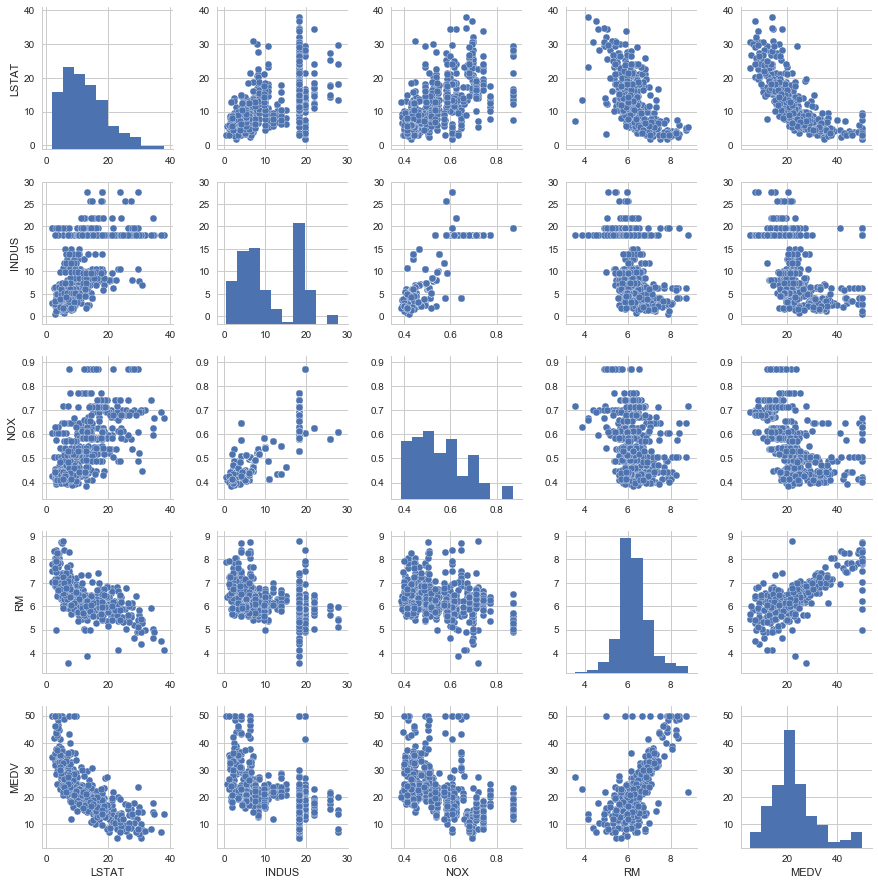

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], size=2.5);
plt.show()

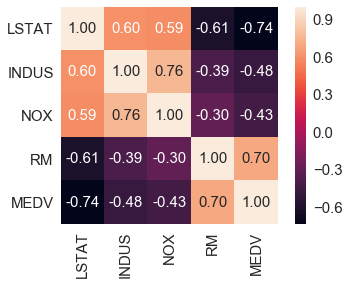

In [3]:
### use numpy's corrcoef to create a visualized scatterplot matrix

import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                annot_kws={'size': 15},
                yticklabels=cols,
                xticklabels=cols)
plt.show()

### Implementing an OLS regression model

In [10]:
### adaline solution to Linear Regression

class LinearRegressionGD(object):
    
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() /2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return self.net_input(X)

In [20]:
X = df[['RM']].values
y = df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
lr = LinearRegressionGD()
lr.fit(X_std, y)

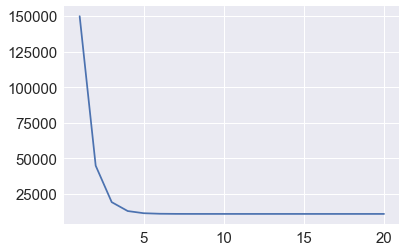

In [21]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.show()

In [22]:
# Plot regression line against data

def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color = 'red')
    return None

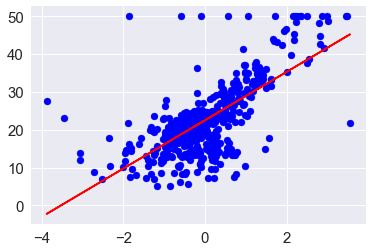

In [23]:
lin_regplot(X_std, y, lr)
plt.show()

#### Implementation in SK-learn

In [24]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept:%.3f' % slr.intercept_)

Slope: 9.102
Intercept:-34.671


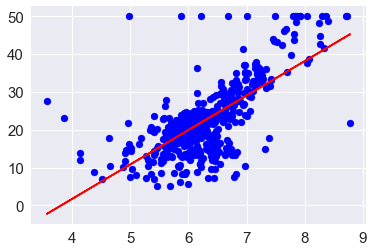

In [25]:
lin_regplot(X, y, slr)
plt.show()

Classic chapter on linear regression: http://www.le.ac.uk/users/dsgp1/COURSES/MESOMET/ECMETXT/06mesmet.pdf.

### Fitting a robust regression using RANSAC

Robust regression using RANdom SAmple Consensus (RANSAC) algorithm which fits a regression to a sample. 

Step:
1. Select random number of samples to be inliers and fit the model
2. Test all other datapoints against the fitted model and add those points within tolerance to the sample
3. Refit the model using all inliers
4. Estimate the error versus the inliers
5. Terminate the algorithm if the performance meets a certain user defined threshold or if a fixed number of iterations has been reached.

In [38]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                        max_trials=100,
                        min_samples=50,
                        residual_metric=lambda x: np.sum(np.abs(x), axis=1),
                        residual_threshold=5.0,
                        random_state=5)
ransac.fit(X, y)

### uses Median Absolute Deviation on the target values y

/Users/andrew.moskowitz/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/ransac.py:288: DeprecationWarning: 'residual_metric' was deprecated in version 0.18 and will be removed in version 0.20. Use 'loss' instead.
  DeprecationWarning)


RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=5,
        residual_metric=<function <lambda> at 0x1a19f82578>,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

##### Article for selecting good inlier threshold

R. Toldo and A. Fusiello's. Automatic Estimation of the Inlier Threshold in Robust Multiple Structures Fitting (in Image Analysis and Processing–ICIAP 2009, pages 123–131. Springer, 2009

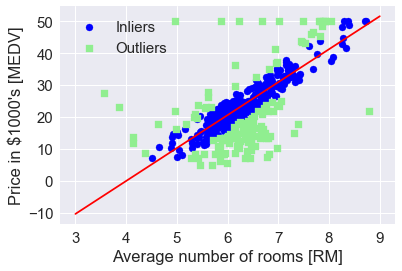

In [39]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3,10,1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [40]:
print('slope: %.3f' % ransac.estimator_.coef_[0])

slope: 10.331


In [41]:
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Intercept: -41.373


### Evaluating the performance of linear regression models

Generally, same idea as training and test sets

In [42]:
from sklearn.cross_validation import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)


/Users/andrew.moskowitz/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


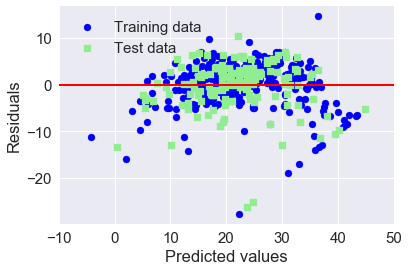

In [43]:
### Plot a residual plot to diagnose model

plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c = 'lightgreen', marker = 's', label = 'Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()

In [45]:
### Can also use Mean Squared Error(MSE)

from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test %.3f' % (
mean_squared_error(y_train, y_train_pred),
mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test 27.196


In [48]:
### Can report coefficient of determination (R^2) 
### understood as a standardized version of the MSE
### R^2 = 1- (SSE/SST)
### R^2 can become negative for out of sample tests

from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' %
     (r2_score(y_train, y_train_pred),
     r2_score(y_test, y_test_pred)))



R^2 train: 0.765, test: 0.673


### Using regularized methods for regression

Most popular approaches to regularized regression are the so-called Ridge Regression, Least Absolute Shrinkage and Selection Operator (LASSO) and Elastic Net

*Ridge Regression* is an L2 penalized model where we add the squared sum of the weights to our least squares cost function

L2 = g*Sum(w^2)
BY increasing the hyperparameter g we increase regularization strength and shrink the weights of our model. Don't regularize the intercept

Alternative approach that can lead to sparse models is the LASSO. Certain weights can become Zero- can also be used for feature selection. 

L1 = g*SUM(Abs(w))

LASSO selects at most n variables if m > n. Can compromise between L1 and L2 penalties to overcome some of the limitations ofthe LASSO-- Basically just add both penalties with complementary hyperparameters. 



In [49]:
## Ridge regression

from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)

In [51]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

In [52]:
from sklearn.linear_model import ElasticNet
lasso = ElasticNet(alpha=1.0, l1_ratio=0.5)

### Turning a linear regression model into a curve-polynomial regression

In [54]:
## Leverage the PolynomialFeatures transformer class in sk-learn

from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0,
             586.0])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 298.6, 314.2, 342.2,
             360.8, 368.0, 391.2, 390.8])

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

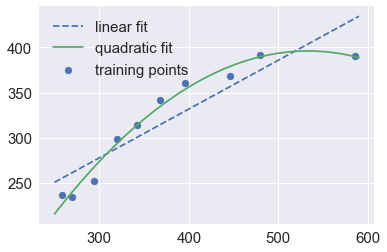

In [55]:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

plt.scatter(X, y, label = 'training points')
plt.plot(X_fit, y_lin_fit, label = 'linear fit', linestyle = '--')
plt.plot(X_fit, y_quad_fit, label = 'quadratic fit')
plt.legend(loc = 'upper left')
plt.show()

In [56]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f, quadratic: %.3f' % (mean_squared_error(y, y_lin_pred),
                                                     mean_squared_error(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330


In [57]:
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
r2_score(y, y_lin_pred),
r2_score(y, y_quad_pred)))

Training R^2 linear: 0.832, quadratic: 0.982


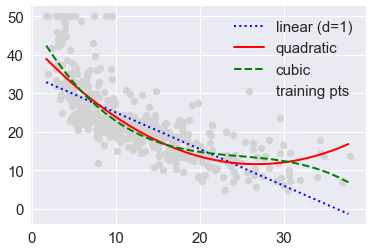

In [61]:
X = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()

quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cibic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

plt.scatter(X, y, label = 'training pts', color = 'lightgray')
plt.plot(X_fit, y_lin_fit, label = 'linear (d=1)', color = 'blue', lw = 2, linestyle=':')
plt.plot(X_fit, y_quad_fit, label = 'quadratic', color = 'red', lw = 2, linestyle = '-')
plt.plot(X_fit, y_cubic_fit, label = 'cubic', color = 'green', lw=2, linestyle='--')
plt.legend(loc = 'upper right')
plt.show()

In [63]:
## Can often transform variables to get a good linear prediction

X_log = np.log(X)
y_sqrt = np.sqrt(y)

X_fit = np.arange(X_log.min()-1, X_log.max() +1, 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

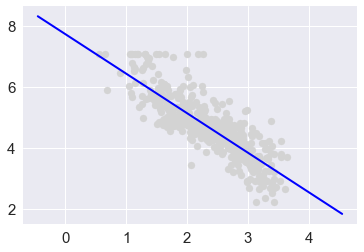

In [66]:
plt.scatter(X_log, y_sqrt, label = 'training points', color = 'lightgray')
plt.plot(X_fit, y_lin_fit,
        label = 'linear',color = 'blue', lw = 2)
plt.show()

### Dealing with Nonlinear relationships using Random Forests

using random forests to sum a piecewise linear finctions that constuch smaller linear spaces that fit a nonlienar dataset

#### Decision Tree Regression

The goal is to maximize information gain for each binary split where:

IG(Dp,X) = I(Dp) - (1/N_p * I)

Here X is the feature to perform the split on, Np is the number of sample sin the parent node. I Is the impurity function and Dp is the subset of training samples in the parent Node. We want to find some split that minimizes impurities in the child node. 

In Decision tree regression we use MSE as the impurity measure (contrasted to entropy)

MSE is also known as within node variance. 

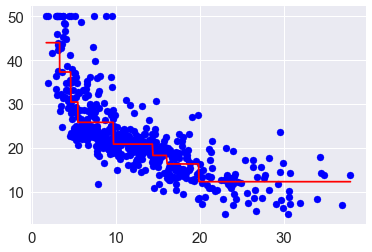

In [67]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.show()

#### Random forest Regression

Ensemble learning on the above decision trees


In [69]:
X = df.iloc[:, :-1].values
y=df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.4, random_state = 1)
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(criterion='mse', random_state = 1,
                              n_jobs=-1)

forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('R^2 train: %.3f, test: %.3f' % (
r2_score(y_train, y_train_pred),
r2_score(y_test, y_test_pred)))

R^2 train: 0.969, test: 0.834


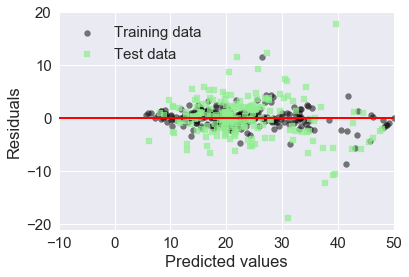

In [70]:
>>> plt.scatter(y_train_pred,  
...             y_train_pred - y_train, 
...             c='black', 
...             marker='o', 
...             s=35,
...             alpha=0.5,
...             label='Training data')
>>> plt.scatter(y_test_pred,  
...             y_test_pred - y_test, 
...             c='lightgreen', 
...             marker='s', 
...             s=35,
...             alpha=0.7,
...             label='Test data')
>>> plt.xlabel('Predicted values')
>>> plt.ylabel('Residuals')
>>> plt.legend(loc='upper left')
>>> plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
>>> plt.xlim([-10, 50])
>>> plt.show()